In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import requests
import math

## Hyperparameters

In [2]:
batch_size = 4
context_length = 16
d_model = 64
num_heads = 4

## Dataset Processing

- https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/tree/main

In [3]:
# get the dataset
# - https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/tree/main
if not os.path.exists('sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/resolve/main/sales_textbook.txt?download=true'
    with open('sales_textbook.txt', 'wb') as f:
      f.write(requests.get(url).content)

with open('sales_textbook.txt', 'r') as f:
    text = f.read()

In [ ]:
text

### Tokenization

In [ ]:
!pip install tiktoken

In [6]:
# https://github.com/openai/tiktoken
import tiktoken
enc = tiktoken.get_encoding("cl100k_base") # c1100l_base is the toknizer

# tokenize
tokens = enc.encode(text)
tokens = torch.tensor(tokens, dtype=torch.long)
max_token_value = tokens.max().item()

In [ ]:
tokens, len(tokens), max_token_value

### Split the dataset

In [8]:
train_idex = int(len(tokens) * 0.9)
train_data = tokens[:train_idex]
val_data = tokens[train_idex:]

In [ ]:
len(train_data), len(val_data)

In [ ]:
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
x_batch = torch.stack([torch.tensor(data[idx:idx+context_length]) for idx in idxs])
y_batch = torch.stack([torch.tensor(data[idx+1:idx+context_length+1]) for idx in idxs])

In [ ]:
x_batch.size(), y_batch.size()

In [ ]:
import pandas as pd

pd.DataFrame(x_batch[0].numpy())
enc.decode(x_batch[0].numpy())

# Transformer

## Input Embeddings and Positional Encoding

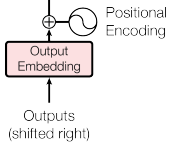

### Input Embeddings

In [13]:
# define input embedding table
input_embedding_table = nn.Embedding(num_embeddings=max_token_value+1, embedding_dim=d_model)

In [ ]:
input_embedding_table.weight.shape, input_embedding_table.weight.data

In [15]:
x_batch_embedding = input_embedding_table(x_batch)
y_batch_embedding = input_embedding_table(y_batch)

In [ ]:
x_batch_embedding.shape, y_batch_embedding.shape

### Positional Encoding

In [17]:
# get positional encoding
def get_positional_encoding(d_model, context_length):
    positional_encoding = torch.zeros(context_length, d_model)
    for pos in range(context_length):
        for i in range(0, d_model, 2):
            positional_encoding[pos, i] = torch.sin(torch.tensor(pos / (10000 ** ((2 * i) / d_model)), dtype=torch.float32))
            positional_encoding[pos, i + 1] = torch.cos(torch.tensor(pos / (10000 ** ((2 * (i + 1)) / d_model)), dtype=torch.float32))
    return positional_encoding

In [18]:
x = x_batch_embedding + get_positional_encoding(d_model, context_length)
y = y_batch_embedding + get_positional_encoding(d_model, context_length)

In [ ]:
pd.DataFrame(x[0].detach().numpy())

## Transformer Block

### Maksed Multi-Head Attention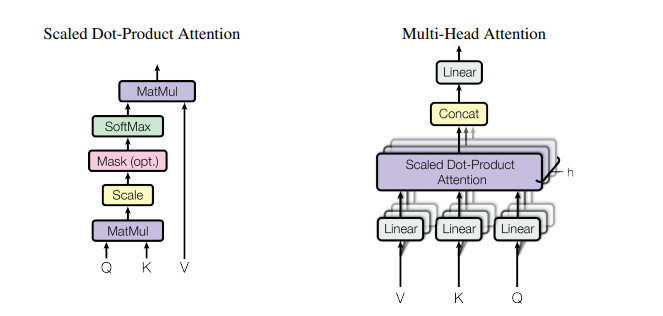


In [20]:
# get Q, K, V
Wq = nn.Linear(in_features=d_model, out_features=d_model)
Wk = nn.Linear(in_features=d_model, out_features=d_model)
Wv = nn.Linear(in_features=d_model, out_features=d_model)

Q = Wq(x)  # Wq*x
K = Wk(x)  # Wk*x
V = Wv(x)  # Wv*x

In [ ]:
Q.shape, K.shape, V.shape

In [22]:
# apply multi head
Q = Q.view(batch_size, context_length, num_heads, d_model // num_heads)
K = K.view(batch_size, context_length, num_heads, d_model // num_heads)
V = V.view(batch_size, context_length, num_heads, d_model // num_heads)

Q = Q.permute(0, 2, 1, 3)
K = K.permute(0, 2, 1, 3)
V = V.permute(0, 2, 1, 3)

In [ ]:
Q.shape, K.shape, V.shape

In [24]:
# apply scaled dot-product
output = Q @ K.transpose(-2, -1) / math.sqrt(d_model // num_heads)

In [25]:
# apply mask
mask = torch.tril(torch.ones(context_length, context_length))
output = output.masked_fill(mask == 0, float('-inf'))

In [26]:
# apply softmax
attention_score = F.softmax(output, dim=-1)

In [27]:
# apply attention @ V
A = attention_score @ V

In [28]:
# apply concat
A = A.transpose(1, 2).contiguous().view(batch_size, context_length, d_model)
Wo = nn.Linear(in_features=d_model, out_features=d_model)
output = Wo(A)

In [ ]:
output.shape

### Add & Norm
add_norm.png



In [30]:
# apply residual connection
output = output + x

In [31]:
# apply layer normalization
layer_norm = nn.LayerNorm(d_model)
layer_norm_output = layer_norm(output)

### Feed Forward Network

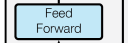

In [32]:
# apply feed forware network
output = nn.Linear(in_features=d_model, out_features=d_model * 4)(layer_norm_output)
output = nn.ReLU()(output)
output = nn.Linear(in_features=d_model * 4, out_features=d_model)(output)

In [ ]:
# apply Add & Norm
output = output + layer_norm_output
output = layer_norm(output)
output.shape

## Linear

In [ ]:
# define final linear layer
output = nn.Linear(in_features=d_model, out_features=max_token_value+1)(output)

output.shape

## Softmax and Output Probabilities

In [35]:
# apply softmax to get output probabilities
logits = F.softmax(output, dim=-1)

In [ ]:
# get the final output
predicted_indx = torch.argmax(logits[0, 0], dim=-1).item()

# decode
enc.decode([predicted_indx])